In this notebook, we build some k Nearest Neighbor models.

We find that if accuracy is an important metric to us, this is a decent model. We want to use 1 neighbor (because more gives us the same accuracy, but takes more computing power), and we can either use all the features, or just use `features_acc=['UNPAID_MONTHS', 'AGE_BY10', 'SEX', 'AVE_BILL_AMT', 'AGE/LIM']` (again, we get the same accuracy either way).  We also want to use the default metric on the underlying space.

If recall is an important metric to us, this is not a very good model to use at all.

Along the way, we also looked at each feature to see if just using if the person did better or worse than average to predict default was useful.  For recall, the UNPAID_MONTHS performed well and it performed decently when measured against accuracy.  For accuracy, the features PAY_AMT1 and AVE_PAY_AMT performed best, but the recall was low.

## Importing packages and data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [5]:
df=pd.read_csv('clean_data_2.csv')

## Splitting the data

In [6]:
train, val = train_test_split(df,
                              test_size=0.1,
                              stratify=df["Y"],
                              shuffle=True,
                              random_state=123)

## A baseline model

Let's use average payment history - if their payment history (based on AVE_PAY) is better than average (or the same), predict 0 and if their payment history is worse than average, predit 1.

This model gets more things wrong than it gets things right.

In [7]:
baseline_pred = pd.DataFrame({'Y':[np. nan for i in range(len(train))]})

In [8]:
ave_AVE_PAY = train['AVE_PAY'].mean()
#for i in range(10):
for i in range(len(train)):
    #print(df.iloc[i]['AVE_PAY'])
    if df.iloc[i]['AVE_PAY'] <= ave_AVE_PAY:
        baseline_pred.at[i,'Y']=0
    else:
        baseline_pred.at[i,'Y']=1
    

### Checking how good the model is

In [9]:
baseline_pred.value_counts()

Y  
1.0    16817
0.0    10183
dtype: int64

In [10]:
confusion_matrix(train['Y'],baseline_pred['Y'])

array([[ 7942, 13086],
       [ 2241,  3731]], dtype=int64)

In [11]:
print('Baseline accuracy:')
print(np.round(accuracy_score(train['Y'],baseline_pred['Y']),5))

Baseline accuracy:
0.43233


In [12]:
print('Baseline recall:')
print(np.round(recall_score(train['Y'],baseline_pred['Y']),5))

Baseline recall:
0.62475


## A first model
Using all of the features we found to have a strong or weak correlation during EDA

Using kfold cross-validation, we find that k=1 is the best by a small margin, and the type of metric used doesn't seem to matter.

This model as a much higher accuracy but lower recall than the baseline model.


In [13]:
features1=['SEX', 
           'EDUCATION', 
           'MARRIAGE', 
           'PAY_1',
           'PAY_AMT1',
           'AGE_BY10', 
           'AVE_PAY', 
           'AGE/LIM', 
           'AVE_BILL_AMT',
           'AVE_BILL_AMT/LIM', 
           'AVE_PAY_AMT',
           'AVE_PAY_AMT/LIM',  
           'AVE_PAY/BILL', 
           'UNPAID_MONTHS']

#### Finding an optimal $k$

In [14]:
def knn_1(j, splits):
    '''goes through k in range(1,j+1) on kNN models on training set.
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((j,splits))
    recs = np.zeros((j,splits))
    for i in range(j):
        x=0
        for train_index, test_index in kfold.split(train[features1], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1*(i+1))
            kNN.fit(
                train.iloc[train_index][features1],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features1]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [15]:
metrics=knn_1(10,5)

metrics

(array([[0.69185185, 0.69425926, 0.68703704, 0.68518519, 0.69703704],
        [0.76648148, 0.76592593, 0.75740741, 0.76111111, 0.76537037],
        [0.73759259, 0.74185185, 0.72222222, 0.73259259, 0.73814815],
        [0.77148148, 0.77055556, 0.76407407, 0.76111111, 0.7687037 ],
        [0.75666667, 0.7562963 , 0.7462963 , 0.74851852, 0.75518519],
        [0.775     , 0.77166667, 0.76944444, 0.77222222, 0.77351852],
        [0.76759259, 0.76166667, 0.75981481, 0.76388889, 0.76759259],
        [0.77259259, 0.77666667, 0.77111111, 0.775     , 0.77981481],
        [0.77      , 0.76944444, 0.76518519, 0.77537037, 0.77351852],
        [0.77537037, 0.78074074, 0.77444444, 0.77981481, 0.78388889]]),
 array([[0.30209205, 0.28451883, 0.30150754, 0.31155779, 0.29648241],
        [0.11548117, 0.10962343, 0.11306533, 0.12562814, 0.10720268],
        [0.21924686, 0.24351464, 0.23115578, 0.2361809 , 0.2160804 ],
        [0.11882845, 0.12384937, 0.11557789, 0.11306533, 0.10217755],
        [0.1807531

More neighbors gives us higher accuracy and lower recall.  

We recall that accuracy is the percent of correct predictions, and 
recall  is the percent of correct predictions when we strict ourselves to  only those who actually defaulted.

So as we use more neighbors, the number of False Negatives increases.  We're guessing that less people will default (which makes sense, since the majority of people don't default).  So, what matters more to our stake holders?

A cursory look makes it seem we should either pick k=1 or k=3, but let's look at the pictures.

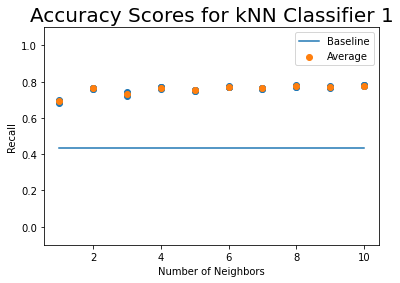

In [16]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics[0], axis=1), label='Average')

plt.plot([1,10],
        [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Accuracy Scores for kNN Classifier 1', fontsize=20)
plt.xlabel('Number of Neighbors')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

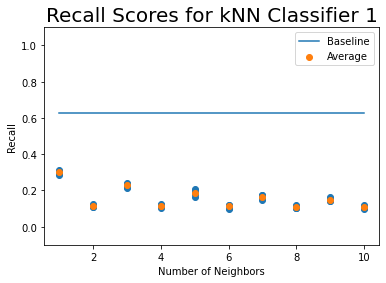

In [17]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics[1], axis=1), label='Average')

plt.plot([1,10],
        [recall_score(train['Y'],baseline_pred['Y']),recall_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Recall Scores for kNN Classifier 1', fontsize=20)
plt.xlabel('Number of Neighbors')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

Actually, looking at this visually we might be best off with k=1, since recall is significantly higher and accuracy really isn't all that different.

#### Finding a good metric

The metrics and their descriptions are here:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics

In [18]:
metric_types=['cityblock', 'cosine', 'euclidean','l1','l2','manhattan','nan_euclidean']

In [19]:
def knn_2(splits):
    '''
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((len(metric_types),splits))
    recs = np.zeros((len(metric_types),splits))
    for i in range(len(metric_types)):
        x=0
        for train_index, test_index in kfold.split(train[features1], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1,
                                       metric=metric_types[i]
                                      )
            kNN.fit(
                train.iloc[train_index][features1],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features1]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [20]:
metrics2=knn_2(5)

metrics2

(array([[0.69481481, 0.7012963 , 0.69055556, 0.68962963, 0.70074074],
        [0.68888889, 0.68407407, 0.68425926, 0.68740741, 0.68462963],
        [0.69185185, 0.69425926, 0.68703704, 0.68518519, 0.69703704],
        [0.69481481, 0.7012963 , 0.69055556, 0.68962963, 0.70074074],
        [0.69185185, 0.69425926, 0.68703704, 0.68518519, 0.69703704],
        [0.69481481, 0.7012963 , 0.69055556, 0.68962963, 0.70074074],
        [0.69185185, 0.69425926, 0.68703704, 0.685     , 0.69703704]]),
 array([[0.30543933, 0.29790795, 0.30569514, 0.319933  , 0.30737018],
        [0.26778243, 0.28033473, 0.27973199, 0.28559464, 0.27721943],
        [0.30209205, 0.28451883, 0.30150754, 0.31155779, 0.29648241],
        [0.30543933, 0.29790795, 0.30569514, 0.319933  , 0.30737018],
        [0.30209205, 0.28451883, 0.30150754, 0.31155779, 0.29648241],
        [0.30543933, 0.29790795, 0.30569514, 0.319933  , 0.30737018],
        [0.30209205, 0.28451883, 0.30234506, 0.31155779, 0.29648241]]))

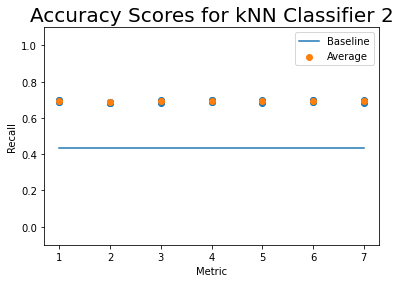

In [21]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7], np.transpose(metrics2[0]).reshape(1,-1))

plt.scatter(range(1,8), np.mean(metrics2[0], axis=1), label='Average')

plt.plot([1,7],
        [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Accuracy Scores for kNN Classifier 2', fontsize=20)
plt.xlabel('Metric')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

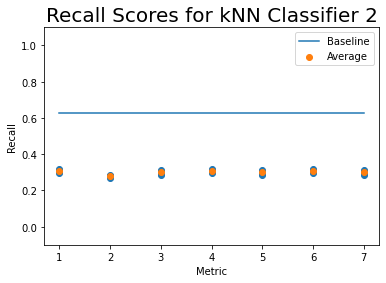

In [22]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7], np.transpose(metrics2[1]).reshape(1,-1))

plt.scatter(range(1,8), np.mean(metrics2[1], axis=1), label='Average')

plt.plot([1,7],
        [recall_score(train['Y'],baseline_pred['Y']),recall_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Recall Scores for kNN Classifier 2', fontsize=20)
plt.xlabel('Metric')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

So the metric doesn't really matter

#### Should the distances be weighted?

In [23]:
def knn_3(splits):
    '''
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    weights=['uniform','distance']
    
    accs=np.zeros((2,splits))
    recs = np.zeros((2,splits))
    for i in range(2):
        x=0
        for train_index, test_index in kfold.split(train[features1], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1,
                                       weights=weights[i]
                                      )
            kNN.fit(
                train.iloc[train_index][features1],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][features1]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [24]:
metrics3=knn_3(5)

metrics3

(array([[0.69185185, 0.69425926, 0.68703704, 0.68518519, 0.69703704],
        [0.69185185, 0.69425926, 0.68703704, 0.68518519, 0.69703704]]),
 array([[0.30209205, 0.28451883, 0.30150754, 0.31155779, 0.29648241],
        [0.30209205, 0.28451883, 0.30150754, 0.31155779, 0.29648241]]))

Well, those aren't different at all

## Deciding if we should really use all the features

Maybe we should have done this before finding $k$...

So if we were to use the powerset of features1 to determine the best subset of features1 to use, we would create and compare 16,384 models.  I don't have the computing power for that, so let's be smarter about which subset to use.

Let's create a series of models that uses the average of each feature individually to decide, and compare the accuracy/recall of those.

We'll ignore marriage and education because those numbers don't actually mean anything, so taking an average doesn't make sense.  We'll leave IN sex because it's binary.

In [26]:
train.groupby(['Y'])['AGE'].mean()

Y
0    35.431805
1    35.714501
Name: AGE, dtype: float64

In [27]:
all_metrics=[]

for feature in features1:
    ave=train[feature].mean()
    
    pred=[]
    accs=[]
    recs=[]
    
    #Assign the prediction to the observation based on which side of the average it is on
    for i in range(len(train)):
        if train.groupby(['Y'])[feature].mean()[0] < ave:
            if train.iloc[i][feature] <=ave:
                pred.append(0)
            else: pred.append(1)
        else:
            if train.iloc[i][feature] > ave:
                pred.append(0)
            else: pred.append(1)
        
    #find the accuracy and recall
    accuracy = accuracy_score(train['Y'],pred)
    recall=recall_score(train['Y'],pred)
    accs.append(accuracy)
    recs.append(recall)
    
    #print the findings
    print(feature)
    print('Accuracy: '+ str(accuracy))
    print('Recall: ' + str(recall))
    print('\n')
    
    #save the findings into the output
    all_metrics.append(accs)
    all_metrics.append(recs)
        

SEX
Accuracy: 0.5744074074074074
Recall: 0.4362022772940388


EDUCATION
Accuracy: 0.43766666666666665
Recall: 0.6950770261219023


MARRIAGE
Accuracy: 0.5362962962962963
Recall: 0.48174815807099797


PAY_1
Accuracy: 0.41574074074074074
Recall: 0.8039182853315472


PAY_AMT1
Accuracy: 0.38381481481481483
Recall: 0.8591761553918286


AGE_BY10
Accuracy: 0.6175925925925926
Recall: 0.32736101808439383


AVE_PAY
Accuracy: 0.4781111111111111
Recall: 0.7268921634293369


AGE/LIM
Accuracy: 0.5681481481481482
Recall: 0.45160750167448094


AVE_BILL_AMT
Accuracy: 0.4003703703703704
Recall: 0.709310113864702


AVE_BILL_AMT/LIM
Accuracy: 0.575037037037037
Recall: 0.549899531145345


AVE_PAY_AMT
Accuracy: 0.41455555555555557
Recall: 0.8369055592766242


AVE_PAY_AMT/LIM
Accuracy: 0.39874074074074073
Recall: 0.7285666443402545


AVE_PAY/BILL
Accuracy: 0.49374074074074076
Recall: 0.6756530475552579


UNPAID_MONTHS
Accuracy: 0.7309629629629629
Recall: 0.6513730743469525




In [28]:
len(all_metrics)

28

In [29]:
recall_scores=[all_metrics[2*i+1] for i in range(14)]
accuracy_scores=[all_metrics[2*i] for i in range(14)]

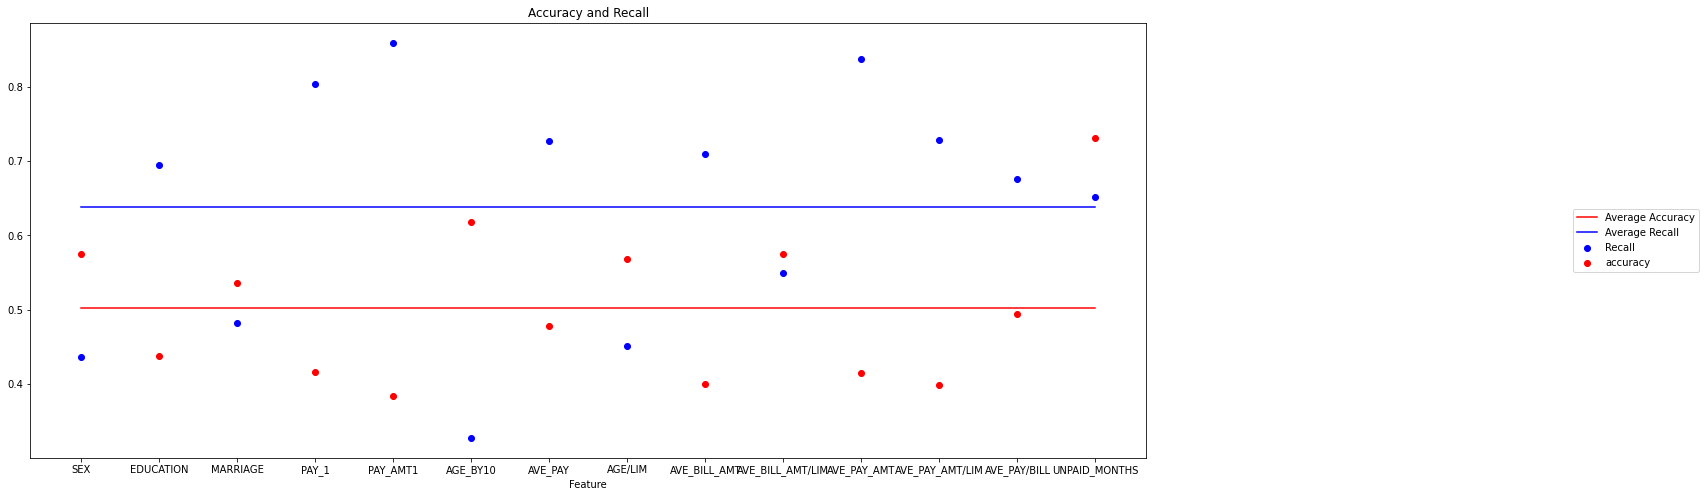

In [30]:
plt.figure(figsize=(20,8))

plt.scatter(features1,
           recall_scores,
           label='Recall',
           color='b')

plt.scatter(features1,
           accuracy_scores,
           label='accuracy',
           color='red')

plt.plot([features1[0], features1[-1]],
        [np.mean(accuracy_scores), np.mean(accuracy_scores)],
        label='Average Accuracy',
        color='red')


plt.plot([0,13],
        [np.mean(recall_scores), np.mean(recall_scores)],
        label='Average Recall',
        color='blue')

plt.title('Accuracy and Recall')

plt.xlabel('Feature')

plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

plt.show()

If accuracy is the only important thing to us, the best features to use are: unpaid_months, age_by10 (what?!), sex, ave_bill_amt, and age/lim

If recall is the only important thing to us, the best features to use are: pay_amt1, ave_pay_amt, pay_1, ave_pay, and ave_pay_amt/lim

If recall and accuracy are equally important to us, the best featuers to use are:
unpaid_months, ave_pay/bill, ave_pay, ave_bill_amt/lim

So, let's build some knn models using just these features

In [31]:
features_acc=['UNPAID_MONTHS', 'AGE_BY10', 'SEX', 'AVE_BILL_AMT', 'AGE/LIM']
features_rec=['PAY_AMT1', 'AVE_PAY_AMT', 'PAY_1', 'AVE_PAY', 'AVE_PAY_AMT/LIM']
features_both=['UNPAID_MONTHS', 'AVE_PAY/BILL', 'AVE_PAY', 'AVE_BILL_AMT/LIM']

In [32]:
for feat in features_both:
    train[feat]

In [33]:
def knn_4(fs, j, splits):
    '''goes through k in range(1,j+1) on kNN models on training set.
    splits is the number of splits in the stratifiedkfold
    features is hard-coded in
    
    Creates an array of precisions and recalls, to be processed'''
    
    kfold=StratifiedKFold(n_splits=splits,
                         shuffle=True,
                         random_state=123)
    
    accs=np.zeros((j,splits))
    recs = np.zeros((j,splits))
    for i in range(j):
        x=0
        for train_index, test_index in kfold.split(train[fs], train['Y']):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1*(i+1))
            kNN.fit(
                train.iloc[train_index][fs],
                train.iloc[train_index]['Y']
                    )
            pred=kNN.predict(train.iloc[test_index][fs]
                        )

            # add metrics to the tables
            accs[i,x]=accuracy_score(train.iloc[test_index]['Y'], pred)
            recs[i,x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
            x=x+1

    return(accs, recs)

In [34]:
knn_foracc=knn_4(features_acc,5,5)
knn_forrec=knn_4(features_rec,5,5)
knn_forboth=knn_4(features_both,5,5)

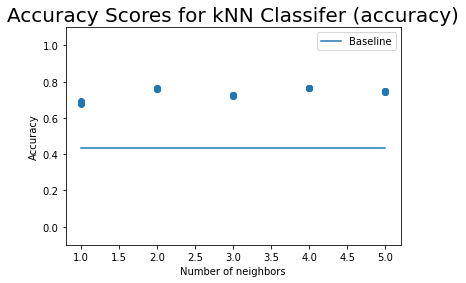

In [35]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_foracc[0]).reshape(1,-1))

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')

plt.plot([1,5],
        [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Accuracy Scores for kNN Classifer (accuracy)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

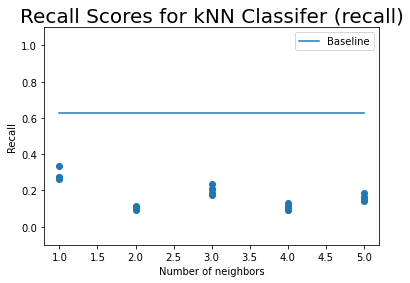

In [36]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forrec[1]).reshape(1,-1))

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')

plt.plot([1,5],
        [recall_score(train['Y'],baseline_pred['Y']),recall_score(train['Y'],baseline_pred['Y'])],
        label='Baseline')

plt.title('Recall Scores for kNN Classifer (recall)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

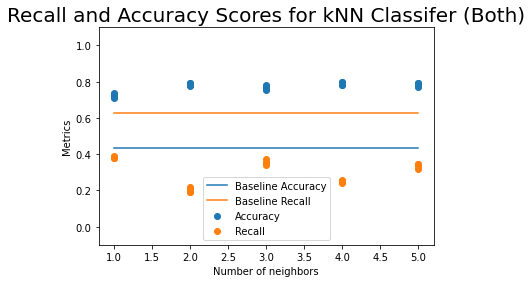

In [37]:
#plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forboth[0]).reshape(1,-1),
           label='Accuracy')

plt.scatter(5*[1,2,3,4,5], np.transpose(knn_forboth[1]).reshape(1,-1),
           label='Recall')

#plt.scatter(range(1,5), np.mean(knn_foracc[0], axis=1), label='Average')

plt.plot([1,5],
        [accuracy_score(train['Y'],baseline_pred['Y']),accuracy_score(train['Y'],baseline_pred['Y'])],
        label='Baseline Accuracy')

plt.plot([1,5],
        [recall_score(train['Y'],baseline_pred['Y']),recall_score(train['Y'],baseline_pred['Y'])],
        label='Baseline Recall')

plt.title('Recall and Accuracy Scores for kNN Classifer (Both)', fontsize=20)
plt.xlabel('Number of neighbors')
plt.ylabel('Metrics')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [38]:
np.mean(metrics[1][0])

0.2992317234709111

In [39]:
np.mean(knn_forboth[1][2])

0.3551601802597366

## Testing the models on the validation data

First model using all the features

In [40]:
kNN1= KNeighborsClassifier(n_neighbors=1)

In [41]:
kNN1.fit(train[features1], train['Y'])

pred1=kNN1.predict(val[features1])

In [45]:
print('Validation set')
print('Accuracy score: ' + str(np.round(accuracy_score(val['Y'], pred1),4)))
print('Recall score: ' + str(np.round(recall_score(val['Y'], pred1),4)))


Validation set
Accuracy score: 0.6883
Recall score: 0.3087


Second model with specialized features

In [46]:
kNN2 = KNeighborsClassifier(n_neighbors=3)

In [47]:
kNN2.fit(train[features_both], train['Y'])

pred2=kNN2.predict(val[features_both])

In [48]:
print('Validation set')
print('Accuracy score: ' + str(np.round(accuracy_score(val['Y'], pred2),4)))
print('Recall score: ' + str(np.round(recall_score(val['Y'], pred2),4)))


Validation set
Accuracy score: 0.759
Recall score: 0.2877
